In [33]:
import requests
import uuid

In [34]:
# API PARAMETERS
BASE_URL = "http://localhost:8080"

TEST_URL = "https://www.gutenberg.org/cache/epub/55/pg55-images.html"
# TEST_FILENAME = "the_tinwoodman_html"
TEST_QUERY = "When does Dorothy meet the Scarecrow?"

#### IMPORTANT
Start up your backend locally for testing
> run docker compose up --build

In [35]:
import asyncio
import aiohttp


async def run_test_async(session, target_chunk_size=800, sentence_overlap=2,
                         small_paragraph_length=200, small_paragraph_overlap=2):

    book_data_payload = {
        "url": TEST_URL,
        "target_chunk_size": target_chunk_size,
        "sentence_overlap": sentence_overlap,
        "small_paragraph_length": small_paragraph_length,
        "small_paragraph_overlap": small_paragraph_overlap
    }

    async with session.post(f"{BASE_URL}/v1/book-data", json=book_data_payload) as response:
        result = await response.json()
        if result.get("status") == "error":
            raise Exception(f"Error in book data upload: {result['message']}")
        filename = result.get("filename", None)

    query_id = str(uuid.uuid4())
    model_payload = {"user_query": TEST_QUERY}

    async with session.post(f"{BASE_URL}/v1/model-response", json=model_payload) as response:
        result = await response.json()
        if result.get("status") == "error":
            raise Exception(f"Error in model response: {result['message']}")

    search_payload = {
        "query": result["search_query"],
        "filenames": [filename],
        "top_k": 3,
        "query_id": query_id,
        "enhanced_query": True
    }

    async with session.post(f"{BASE_URL}/v1/search-response", json=search_payload) as response:
        search_results = await response.json()
        if search_results.get("status") == "error":
            raise Exception(f"Error in search response: {search_results['message']}")
        return search_results, filename

In [36]:
async with aiohttp.ClientSession() as session:
    await run_test_async(session)

In [ ]:
import pandas as pd
import time

# Define parameter combinations to test
PARAM_COMBOS = [
    # (target_chunk_size, sentence_overlap, small_paragraph_length, small_paragraph_overlap)
    (800, 2, 200, 2),   # Default
    (1000, 2, 200, 2),  # Larger chunks
    (1000, 2, 200, 3),  # Larger chunks with more paragraph overlap
    (1000, 2, 150, 3),  # Larger chunks with smaller paragraph threshold
    (600, 2, 200, 2),   # Smaller chunks
    (600, 2, 200, 3),   # Smaller chunks with more paragraph overlap
    (600, 2, 150, 3),   # Smaller chunks with smaller
    (600, 2, 250, 3),   # Smaller chunks with larger paragraph threshold
    (700, 2, 200, 2),   # Medium chunks
    (700, 2, 200, 3),   # Medium chunks with more paragraph overlap
    (700, 2, 150, 3),   # Medium chunks with smaller paragraph threshold
    (800, 3, 200, 2),   # More sentence overlap
    (800, 1, 200, 2),   # Less sentence overlap
    (800, 2, 150, 2),   # Smaller paragraph threshold
    (800, 2, 250, 2),   # Larger paragraph threshold
    (800, 2, 200, 3),   # More paragraph overlap
    (800, 2, 200, 1),   # Less paragraph overlap
]

async def run_all_tests():
    run_id = str(uuid.uuid4())[:8]
    import datetime

    all_results = []

    async with aiohttp.ClientSession() as session:
        for test_num, params in enumerate(PARAM_COMBOS, 1):
            target_chunk_size, sentence_overlap, small_paragraph_length, small_paragraph_overlap = params

            timestamp = datetime.datetime.now().strftime("%H:%M:%S.%f")[:-3]
            print(f"[{timestamp}] [{run_id}] TEST {test_num}: chunk_size={target_chunk_size}")

            search_results, filename = await run_test_async(
                session,
                target_chunk_size=target_chunk_size,
                sentence_overlap=sentence_overlap,
                small_paragraph_length=small_paragraph_length,
                small_paragraph_overlap=small_paragraph_overlap
            )

            # Process results...
            temp_df = pd.read_pickle(f"../temp/{filename}.pkl")
            chunk_lengths = temp_df.chunk_length.tolist()
            avg_chunk_length = temp_df.chunk_length.mean()

            for result_num, result in enumerate(search_results["search_results"], 1):
                result_row = {
                    'test_number': test_num,
                    'result_rank': result_num,
                    'target_chunk_size': target_chunk_size,
                    'sentence_overlap': sentence_overlap,
                    'small_paragraph_length': small_paragraph_length,
                    'small_paragraph_overlap': small_paragraph_overlap,
                    'chapter_index': result['data']['chapter_index'],
                    'chapter_number': result['data']['chapter_number'],
                    'chapter_title': result['data']['chapter_title'],
                    'chunk_in_chapter_index': result['data']['chunk_in_chapter_index'],
                    'score': result['data']['score'],
                    'matched_texts': result['data']['matched_texts'],
                    'avg_chunk_length': avg_chunk_length,
                    'min_chunk_length': min(chunk_lengths),
                    'max_chunk_length': max(chunk_lengths),
                    'all_chunks': chunk_lengths,
                }
                all_results.append(result_row)

    results_df = pd.DataFrame(all_results)
    timestamp = datetime.datetime.now().strftime("%H:%M:%S.%f")[:-3]
    print(f"\n{'='*80}")
    print(f"[{timestamp}] [{run_id}] COMPLETED {len(PARAM_COMBOS)} TESTS")
    print(f"[{timestamp}] [{run_id}] Total results collected: {len(results_df)}")
    print(f"{'='*80}")
    return results_df

In [ ]:
results_df = await run_all_tests()

[09:33:11.963] [453d2fc0] TEST 1: chunk_size=800
[09:33:37.619] [453d2fc0] TEST 2: chunk_size=1000
[09:33:37.619] [453d2fc0] TEST 2: chunk_size=1000
[09:33:53.825] [453d2fc0] TEST 3: chunk_size=1000
[09:33:53.825] [453d2fc0] TEST 3: chunk_size=1000
[09:34:10.624] [453d2fc0] TEST 4: chunk_size=1000
[09:34:10.624] [453d2fc0] TEST 4: chunk_size=1000
[09:34:27.386] [453d2fc0] TEST 5: chunk_size=600
[09:34:27.386] [453d2fc0] TEST 5: chunk_size=600
[09:34:58.539] [453d2fc0] TEST 6: chunk_size=600
[09:34:58.539] [453d2fc0] TEST 6: chunk_size=600
[09:35:28.837] [453d2fc0] TEST 7: chunk_size=600
[09:35:28.837] [453d2fc0] TEST 7: chunk_size=600
[09:36:00.839] [453d2fc0] TEST 8: chunk_size=600
[09:36:00.839] [453d2fc0] TEST 8: chunk_size=600
[09:36:37.089] [453d2fc0] TEST 9: chunk_size=700
[09:36:37.089] [453d2fc0] TEST 9: chunk_size=700
[09:37:02.006] [453d2fc0] TEST 10: chunk_size=700
[09:37:02.006] [453d2fc0] TEST 10: chunk_size=700
[09:37:27.718] [453d2fc0] TEST 11: chunk_size=700
[09:37:27.7

In [ ]:
results_df.head()

,test_number,result_rank,target_chunk_size,sentence_overlap,small_paragraph_length,small_paragraph_overlap,chapter_index,chapter_number,chapter_title,chunk_in_chapter_index,score,matched_texts,avg_chunk_length,min_chunk_length,max_chunk_length,all_chunks
0,1,1,800,2,200,2,3,3,How Dorothy Saved The Scarecrow,7,0.754813,"[{'chunk_index': 28, 'text': 'This worried Dor...",881.143396,144,1501,"[883, 321, 873, 1239, 805, 1116, 836, 1116, 14..."
1,1,2,800,2,200,2,3,3,How Dorothy Saved The Scarecrow,6,0.752520,"[{'chunk_index': 27, 'text': 'When she had tir...",881.143396,144,1501,"[883, 321, 873, 1239, 805, 1116, 836, 1116, 14..."
2,1,3,800,2,200,2,3,3,How Dorothy Saved The Scarecrow,11,0.738708,"[{'chunk_index': 32, 'text': '“Do you think,” ...",881.143396,144,1501,"[883, 321, 873, 1239, 805, 1116, 836, 1116, 14..."
3,2,1,1000,2,200,2,3,3,How Dorothy Saved The Scarecrow,5,0.752298,"[{'chunk_index': 22, 'text': 'When she had tir...",1085.588517,64,1854,"[1140, 64, 1491, 1151, 1364, 1407, 662, 1205, ..."
4,2,2,1000,2,200,2,18,18,Away To The South,6,0.746487,"[{'chunk_index': 174, 'text': '“Glinda is a Go...",1085.588517,64,1854,"[1140, 64, 1491, 1151, 1364, 1407, 662, 1205, ..."


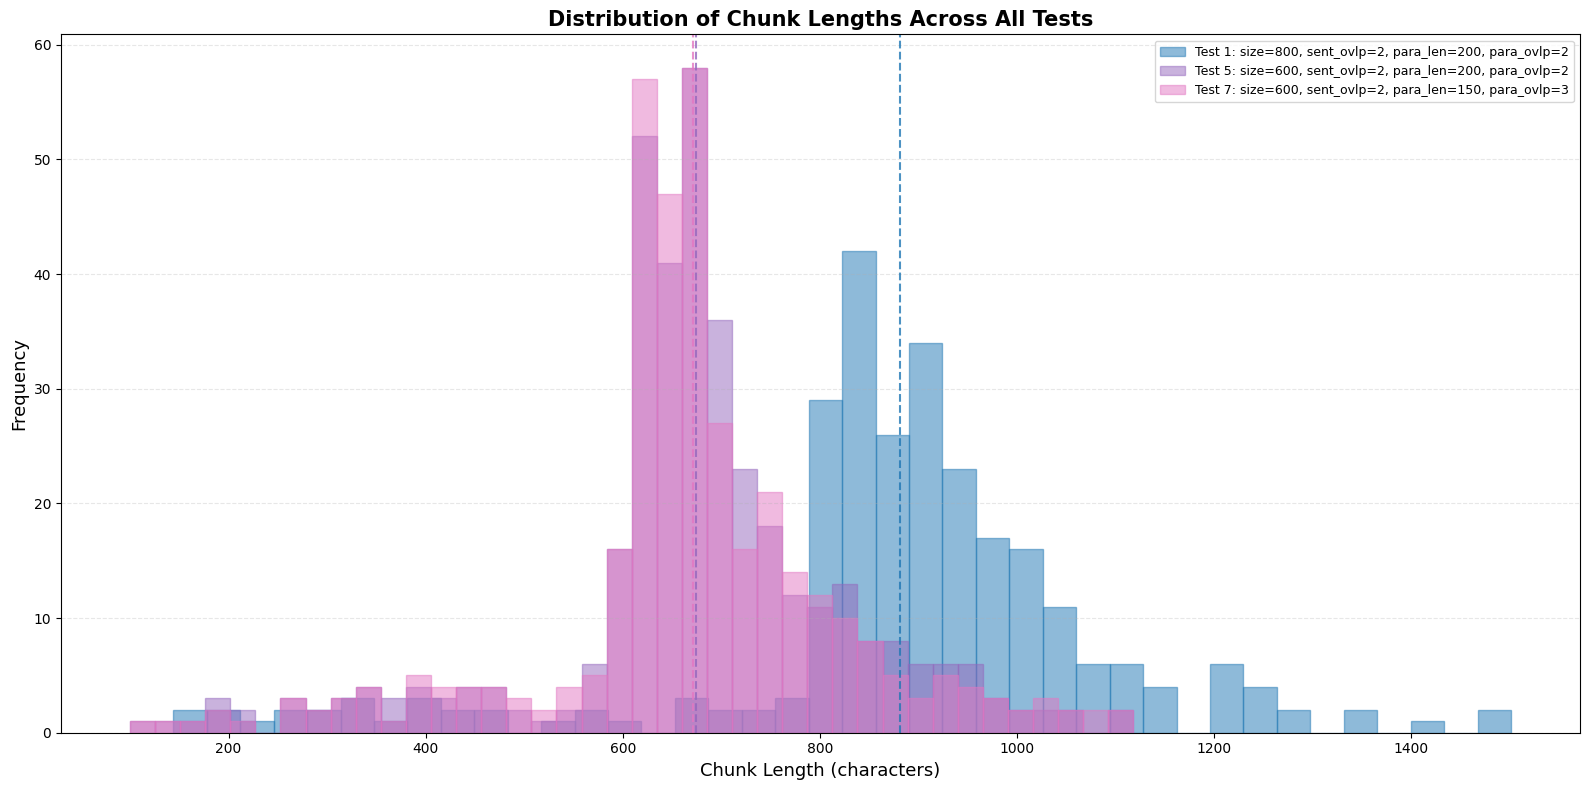


Summary Statistics:
Test 1: Mean=881.1, Std=213.4, Count=265, Params: (800, 2, 200, 2)
Test 2: Mean=1085.6, Std=260.8, Count=209, Params: (1000, 2, 200, 2)
Test 3: Mean=1085.8, Std=263.9, Count=213, Params: (1000, 2, 200, 3)
Test 4: Mean=1091.7, Std=261.0, Count=203, Params: (1000, 2, 150, 3)
Test 5: Mean=674.1, Std=156.9, Count=374, Params: (600, 2, 200, 2)
Test 6: Mean=675.5, Std=156.0, Count=390, Params: (600, 2, 200, 3)
Test 7: Mean=670.7, Std=154.4, Count=367, Params: (600, 2, 150, 3)
Test 8: Mean=686.1, Std=159.5, Count=445, Params: (600, 2, 250, 3)
Test 9: Mean=776.0, Std=188.9, Count=314, Params: (700, 2, 200, 2)
Test 10: Mean=778.4, Std=195.7, Count=321, Params: (700, 2, 200, 3)
Test 11: Mean=775.0, Std=195.4, Count=305, Params: (700, 2, 150, 3)
Test 12: Mean=885.1, Std=208.2, Count=265, Params: (800, 3, 200, 2)
Test 13: Mean=877.1, Std=221.3, Count=265, Params: (800, 1, 200, 2)
Test 14: Mean=876.4, Std=217.4, Count=260, Params: (800, 2, 150, 2)
Test 15: Mean=881.9, Std=207.7

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique test numbers (drop duplicates since each test appears 3 times for top_k=3)
unique_tests = results_df.drop_duplicates(subset='test_number')

# Create color palette
colors = plt.cm.tab10(range(len(unique_tests)))

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot histogram for each test
for idx, (_, test_row) in enumerate(unique_tests.iterrows()):
    test_num = test_row['test_number']

    if test_num not in [1, 5, 7]:
        continue

    chunks = test_row['all_chunks']
    chunk_mean = np.mean(chunks)

    # Create label with parameter info
    label = f"Test {test_num}: size={test_row['target_chunk_size']}, sent_ovlp={test_row['sentence_overlap']}, para_len={test_row['small_paragraph_length']}, para_ovlp={test_row['small_paragraph_overlap']}"

    # Plot histogram
    ax.hist(chunks, bins=40, alpha=0.5, label=label, color=colors[idx], edgecolor=colors[idx])

    # Add mean line
    ax.axvline(chunk_mean, color=colors[idx], linestyle='--', linewidth=1.5, alpha=0.8)

# Labels and styling
ax.set_xlabel('Chunk Length (characters)', fontsize=13)
ax.set_ylabel('Frequency', fontsize=13)
ax.set_title('Distribution of Chunk Lengths Across All Tests', fontsize=15, fontweight='bold')
ax.legend(fontsize=9, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("="*100)
for _, test_row in unique_tests.iterrows():
    chunks = test_row['all_chunks']
    print(f"Test {test_row['test_number']}: Mean={np.mean(chunks):.1f}, "
          f"Std={np.std(chunks):.1f}, Count={len(chunks)}, "
          f"Params: ({test_row['target_chunk_size']}, {test_row['sentence_overlap']}, "
          f"{test_row['small_paragraph_length']}, {test_row['small_paragraph_overlap']})")

In [ ]:
top_picks = results_df[results_df['result_rank'] == 1]

for _, row in top_picks.iterrows():
    matched_text = row['matched_texts']
    # extract matching texts
    matched_hits = [m.get('text', '') for m in matched_text if m.get('is_match') is True]
    match_text = " ".join(matched_hits) if matched_hits else ""
    print(f"\n\nTEST {row['test_number']}: Score={row['score']:.4f}, "
        f"Chapter {row['chapter_number']} - {row['chapter_title']}, "
        f"\n\nChunk Text={match_text}, \n\n"
        f"Params: ({row['target_chunk_size']}, {row['sentence_overlap']}, "
        f"{row['small_paragraph_length']}, {row['small_paragraph_overlap']})")



TEST 1: Score=0.7548, Chapter 3 - How Dorothy Saved The Scarecrow, 

Chunk Text=While Dorothy was looking earnestly into the queer, painted face of the Scarecrow, she was surprised to see one of the eyes slowly wink at her. She thought she must have been mistaken at first, for none of the scarecrows in Kansas ever wink; but presently the figure nodded its head to her in a friendly way. Then she climbed down from the fence and walked up to it, while Toto ran around the pole and barked.

“Good day,” said the Scarecrow, in a rather husky voice.

“Did you speak?” asked the girl, in wonder.

“Certainly,” answered the Scarecrow. “How do you do?”

“I’m pretty well, thank you,” replied Dorothy politely. “How do you do?”

“I’m not feeling well,” said the Scarecrow, with a smile, “for it is very tedious being perched up here night and day to scare away crows.”, 

Params: (800, 2, 200, 2)


TEST 2: Score=0.7523, Chapter 3 - How Dorothy Saved The Scarecrow, 

Chunk Text=This worried Dorothy a li

There are two main parameters we aim to adjust for:
1. Semantic similarity of chunks
2. Chunk size consistency

Aiming for semantic similarity has benefits of each chunk maintaining contextual information, but then the sizes of each chunk can vary drastically. Aiming for chunk size consistency is to reduce bias towards longer chunks. Very long chunks dominate rankings simply because they contain more tokens that may match your query. Additionally, too small of a chunk and you will find poor semantic representation. Too large of a chunk and you are increasing the noise and can dilute the signal. Lastly, more constitent chunks means better embedding and search performance since the resources required are more predictable chunk by chunk.

Therefore we can take advantage of book structure and but also tune for more consistent chunks...

In [ ]:
results_df.to_csv("../chunking_param_combo_results_113025.csv", index=False)